# GMAC Optimization: Grid search of GMAC parameters

The GMAC algorithm has the following parameters required to map the raw acceleration
data to the arm-use space. These parameters are:
1. Pitch angle threshold. $\left( \theta_{th} \right)$
2. Acceleration magnitude threshold. $\left( a_{th} \right)$

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob

In [3]:
import seaborn as sns

### Custom Modules

In [4]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

In [5]:
import gmac

In [6]:
# Define the font family and size
# font = {'family': 'sans-serif', 'sans-serif': ['Helvetica']}

# # Set the font properties for various elements
# plt.rc('font', **font)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight


## Define notebook level constants

In [7]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

## Read the Controls and Patients Data

In [8]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

# All limbs data ddf
datadf = {
    "left": left,
    "right": right,
    "aff": aff,
    "unaff": unaff
}

### Functions implementing the GMAC algorithm

In [9]:
# Generate all possible combinations of parameters.
def generate_param_combinations(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _np in param_ranges["np"]:
        for _fc in param_ranges["fc"]:
            for _nc in param_ranges["nc"]:
                for _nam in param_ranges["nam"]:
                    for _pth in param_ranges["p_th"]:
                        for _amth in param_ranges["am_th"]:
                            yield {
                                "np": int(_np),
                                "fc": _fc,
                                "nc": int(_nc),
                                "nam": int(_nam),
                                "p_th": _pth,
                                "am_th": _amth
                            }

In [10]:
def compute_confusion_matrix(actual: np.array, estimated: np.array) -> np.array:
    """
    Computes the components of the confusion matrix.
    """
    actual = np.array(actual, dtype=int)
    estimated = np.array(estimated, dtype=int)
    return {
        "TN": np.sum((actual + estimated) == 0), # TN
        "FP": np.sum((1 - actual + estimated) == 2), # FP
        "FN": np.sum((actual + 1 - estimated) == 2), # FN
        "TP": np.sum((actual + estimated) == 2), # TP
    }

#### Parameter ranges for the grid search

In [17]:
basedir = "../data/output-understanding"

# GMAC Parameter ranges
gmac_params = {
    "np": int(Fs // 2),
    "fc": 0.1,
    "nc": 1,
    "nam": int(5*Fs),
    "p_th": 20,
    "p_th_band": 40,
    "am_th": -1
}

In [19]:
accl_cols = ["ax", "ay", "az"]
limbkey = "left"
subj = 2
df = datadf[limbkey][datadf[limbkey].subject==subj]
# Compute gmac
_u_ac = np.hstack([
    gmac.estimate_accl_mag(_df[accl_cols].values, Fs,
                           fc=gmac_params["fc"],
                           nc=gmac_params["nc"],
                           n_am=gmac_params["nam"])
    for _, _df in df.groupby('segment')
])

# # Update gmac df
# _n = len(_gmac)
# _subj_gmac = np.hstack((subj * np.ones((_n, 1)),
#                         _pc["p_th"] * np.ones((_n, 1)),
#                         _pc["am_th"] * np.ones((_n, 1)),
#                         np.hstack(_gmac).reshape(-1, 1),
#                         df.gnd.values.reshape(-1, 1)))
# gmac_df = pd.concat((gmac_df, pd.DataFrame(_subj_gmac, columns=dfcols)),
#                     ignore_index=True)

# # Estimate pitch and acceleration magnitude
# pitch = estimate_pitch(accl, accl_farm_inx, params["np"])
# accl_mag = estimate_accl_mag(accl, Fs, fc=params["fc"], nc=params["nc"],
#                                 n_am=params["nam"])

# # Compute GMAC
# _pout = np.zeros(len(pitch))
# for i in range(1, len(_pout)):
#     if _pout[i-1] == 0:
#         _pout[i] = 1 * (pitch[i] >= params["p_th"])
#     else:
#         _pout[i] = 1 * (pitch[i] >= (params["p_th"] - params["p_th_band"]))
# _amout = 1.0 * (accl_mag > params["am_th"])

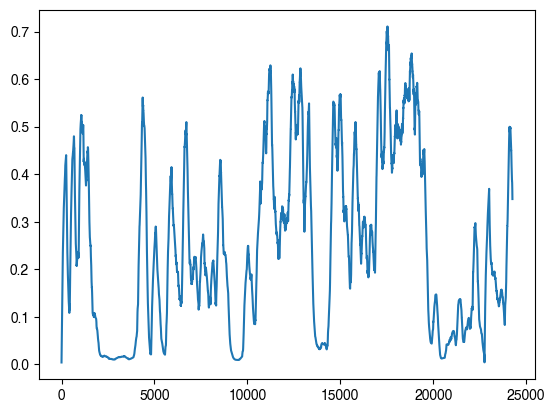

In [20]:
plt.plot(_u_ac)

In [12]:
for limbkey in ["left", "right", "aff", "unaff"]:
    # Make directory if it does not exist
    outdir = pathlib.Path(basedir, limbkey, "gmac")
    outdir.mkdir(parents=True, exist_ok=True)
    
    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()

    # Estimate pitch for each subject.
    accl_cols = ['ax', 'ay', 'az']
    dfcols = ["subject"] + ["p_th", "am_th"] + ["gmac", "gt"]

    # Number of all possible combinations
    Ncombs = len(list(generate_param_combinations(am_param_ranges)))

    # All parameter combinations.
    param_combs = list(generate_param_combinations(am_param_ranges))

    gmac_df = pd.DataFrame(columns=dfcols)
    for i, subj in enumerate(subjects):
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            sys.stdout.write(f"\r{limbkey} {i:3d}, {j:3d}")
            df = limbdf[limbdf.subject==subj]
            # Compute gmac
            _gmac = np.hstack([
                gmac.estimate_gmac(_df[accl_cols].values, accl_farm_inx=0, Fs=Fs,
                                params=_pc)
                for _, _df in df.groupby('segment')
            ])
            # Update gmac df
            _n = len(_gmac)
            _subj_gmac = np.hstack((subj * np.ones((_n, 1)),
                                    _pc["p_th"] * np.ones((_n, 1)),
                                    _pc["am_th"] * np.ones((_n, 1)),
                                    np.hstack(_gmac).reshape(-1, 1),
                                    df.gnd.values.reshape(-1, 1)))
            gmac_df = pd.concat((gmac_df, pd.DataFrame(_subj_gmac, columns=dfcols)),
                                ignore_index=True)
    # Save data
    gmac_df.to_csv(pathlib.Path(basedir, limbkey, "gmac", f"gmac.csv").as_posix(), index=False)


unaff   4,  71

In [13]:
# Read and combine data from different subjects in one file.
_path = pathlib.Path(basedir, "left", "am").as_posix() + "/*-am.csv"
all_gmac_df = {
    _lmb: pd.read_csv(pathlib.Path(basedir, _lmb, "gmac", "gmac.csv").as_posix())
    for _lmb in ["left", "right", "aff", "unaff"]
}

In [14]:
# Compute correlation for all limbs
gmac_perf_df = {}
for _lmb in ["left", "right", "aff", "unaff"]:
    param_combs = list(generate_param_combinations(am_param_ranges))
    # Effect of fc
    _limbdf = all_gmac_df[_lmb]
    cols = ["subj", "fc", "nc", "nam", "p_th", "am_th",
            "TN", "FP", "FN", "TP"]
    gmac_perf_df[_lmb] = pd.DataFrame(columns=cols)
    for i, subj in enumerate(_limbdf["subject"].unique()):
        gmac_df = pd.DataFrame(columns=dfcols)
        # Go through all parameter combinations.
        _sinx = _limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            sys.stdout.write(f"\r{_lmb:>6} {i:3d}, {j:3d}")
            # Parameter index
            _pcinx = ((_limbdf["p_th"] == _pc["p_th"]) &
                      (_limbdf["am_th"] == _pc["am_th"]))
            _perf = compute_confusion_matrix(
                actual=_limbdf.loc[_sinx & _pcinx, "gt"].values,
                estimated=_limbdf.loc[_sinx & _pcinx, "gmac"].values
            )
            # Update amdf
            _rowdf = pd.DataFrame({"subject": subj} | _pc | _perf, index=[0])
            _rowdf[["TNr", "FPr", "FNr", "TPr"]] = _rowdf[["TN", "FP", "FN", "TP"]] / np.sum(_rowdf[["TN", "FP", "FN", "TP"]].values)
            gmac_perf_df[_lmb] = pd.concat(
                (gmac_perf_df[_lmb], _rowdf),
                ignore_index=True
            )

 unaff   4,  71

In [16]:
# Compute different performance metrics
for _lmb in ["left", "right", "aff", "unaff"]:
    # Sensitivity
    gmac_perf_df[_lmb]["sensitivity"] = gmac_perf_df[_lmb].TP / (gmac_perf_df[_lmb].TP + gmac_perf_df[_lmb].FN)
    # Specificity
    gmac_perf_df[_lmb]["specificity"] = gmac_perf_df[_lmb].TN / (gmac_perf_df[_lmb].TN + gmac_perf_df[_lmb].FP)
    # Youden's J
    gmac_perf_df[_lmb]["youden"] = gmac_perf_df[_lmb].sensitivity + gmac_perf_df[_lmb].specificity - 1

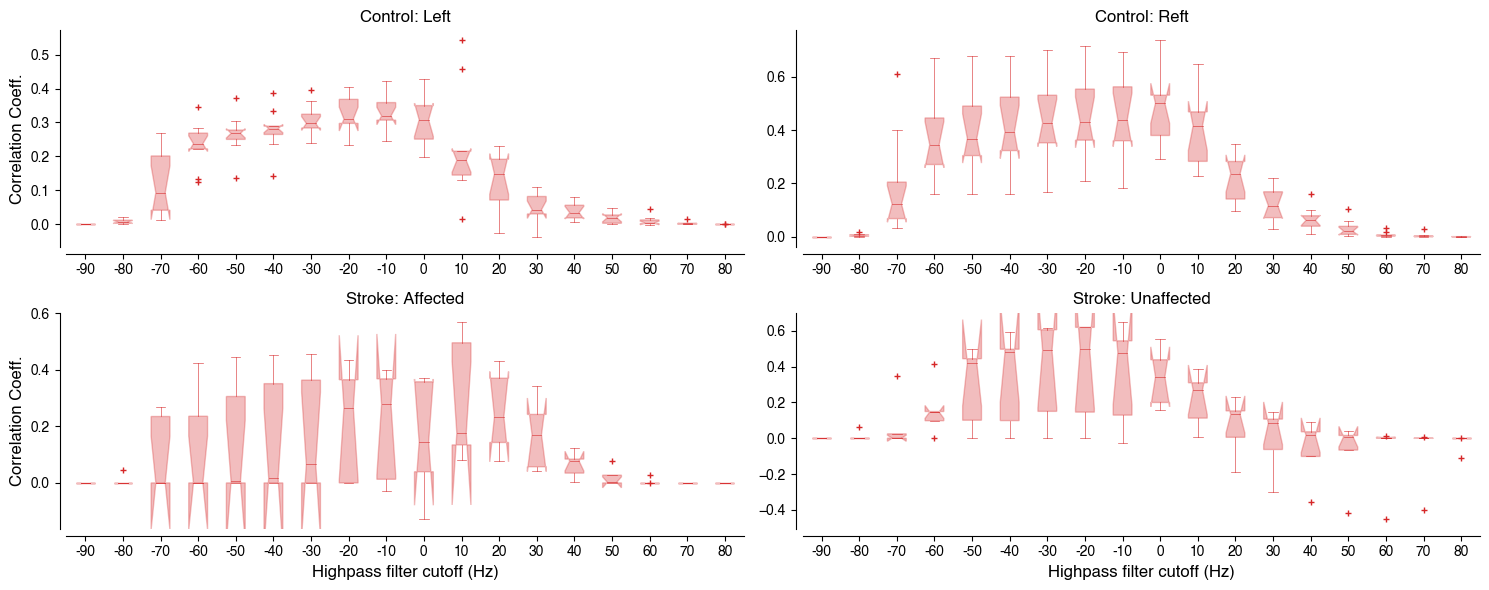

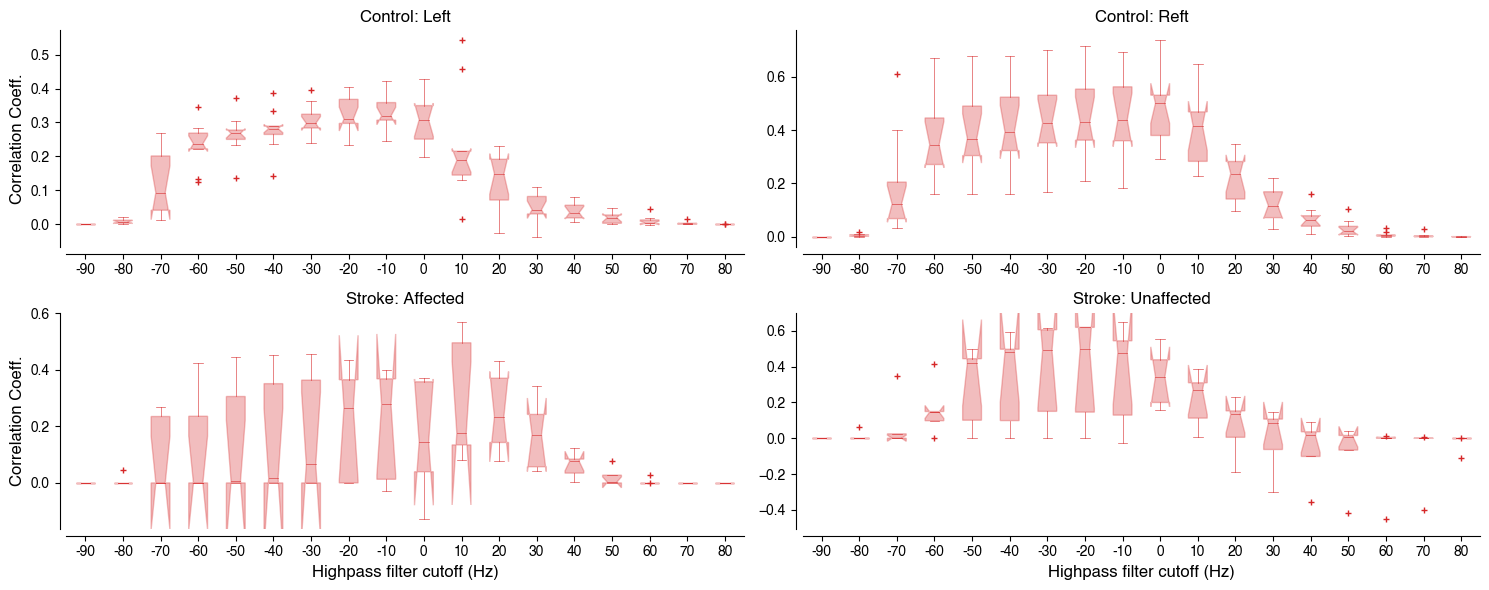

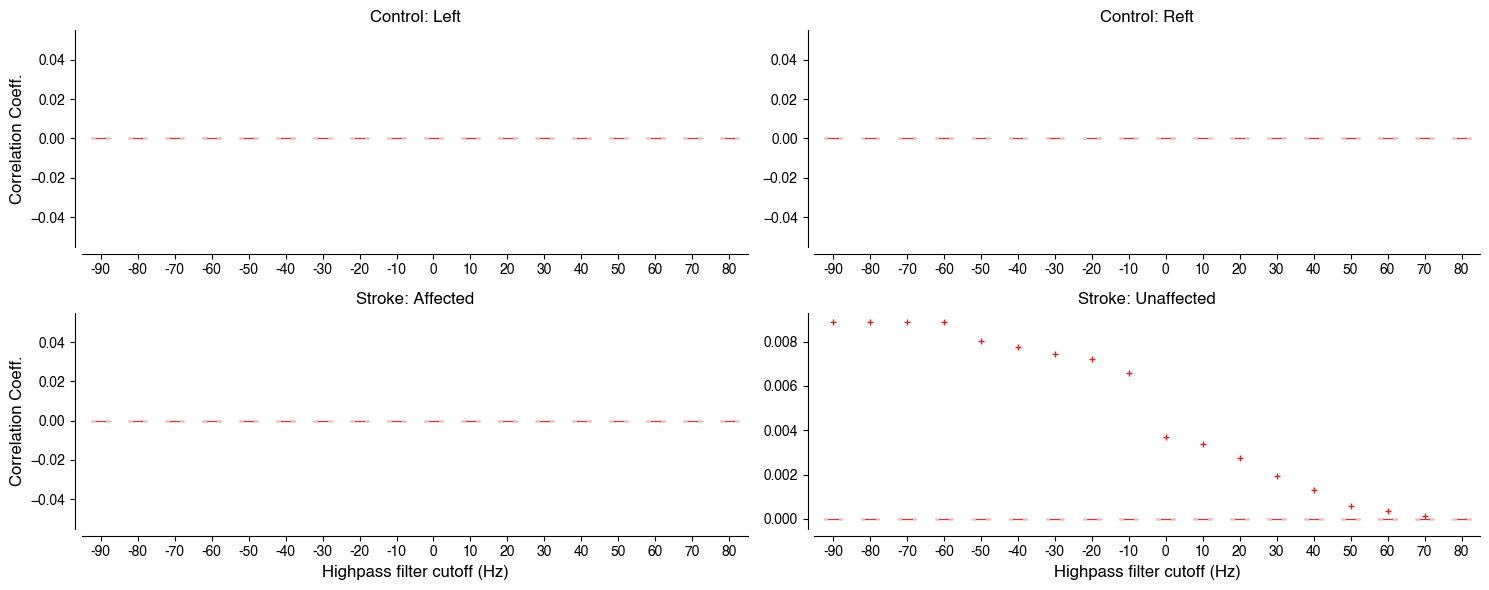

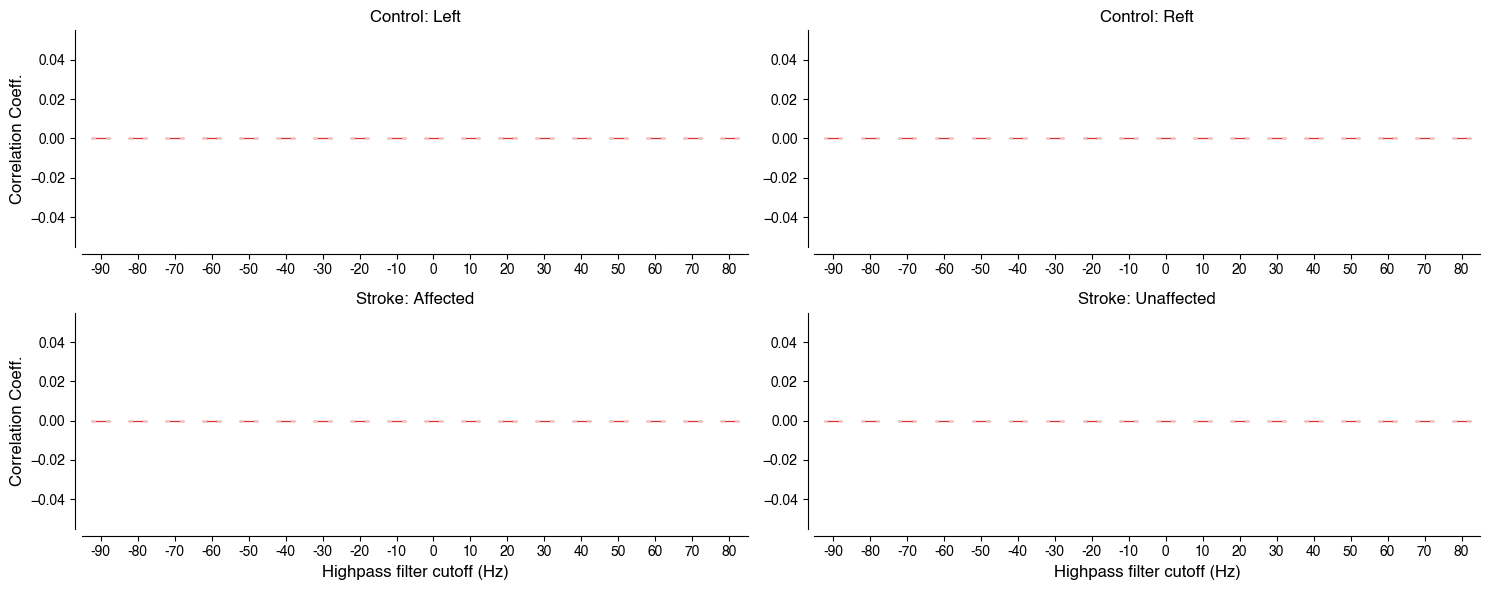

In [17]:
# Effect of pitch threshold.
for j, _amval in enumerate(am_param_ranges["am_th"]):
    fig = plt.figure(figsize=(15, 6))
    for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
        ax = fig.add_subplot(2, 2, j+1)
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) & 
                    (gmac_perf_df[_lmb]["am_th"] == _amval))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            ax.boxplot(x=_yi, positions=[i],
                    widths=0.5, notch=True, patch_artist=True,
                    boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                    capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                    whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                    flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                    markerfacecolor='tab:red', marker='+', markersize=4),
                    medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
            # ax.set_ylim(0.0, 1.0)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_position(('outward', 5))
            ax.spines['bottom'].set_position(('outward', 5))
            ax.set_title(f"{_lmb}", fontsize=12)
            if _lmb == "left":
                ax.set_title("Control: Left", fontsize=12)
            elif _lmb == "right":
                ax.set_title("Control: Reft", fontsize=12)
            elif _lmb == "aff":
                ax.set_title("Stroke: Affected", fontsize=12)
            else:
                ax.set_title("Stroke: Unaffected", fontsize=12)
            
            if j // 2 == 1:
                ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
            if j % 2 == 0:
                ax.set_ylabel("Correlation Coeff.", fontsize=12)
        
        ax.set_xticklabels(am_param_ranges["p_th"])
    plt.tight_layout()

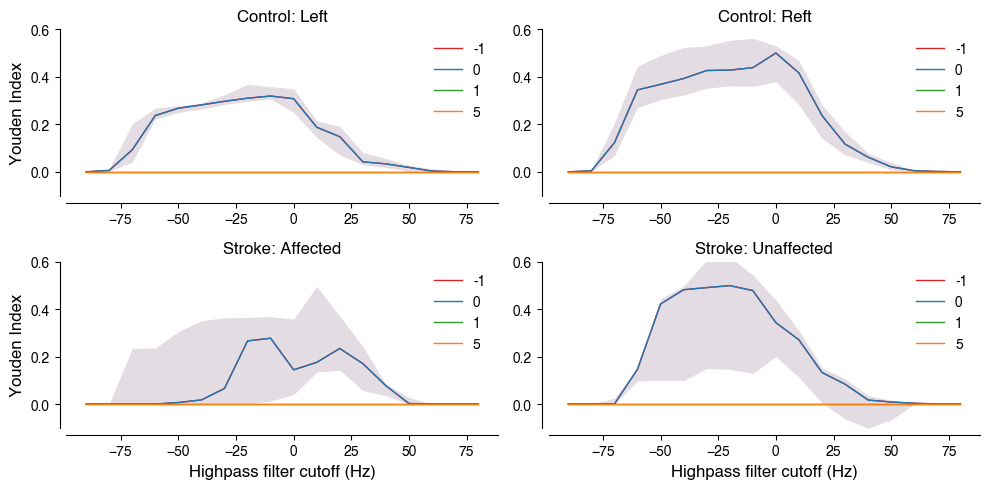

In [18]:
# Effect of pitch threshold.
fig = plt.figure(figsize=(10, 5))
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange"]
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for k, _amval in enumerate(am_param_ranges["am_th"]):
        _yivals = []
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) & 
                    (gmac_perf_df[_lmb]["am_th"] == _amval))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
        
        # Plot values.
        _yivals = np.array(_yivals).astype(float)
        ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                label=f"{_amval}")
        ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                        y2=_yivals[:, 2], color=colors[k], lw=0, alpha=0.1)
        ax.set_ylim(-0.1, 0.6)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Youden Index", fontsize=12)
    ax.legend(loc=0, fontsize=10, frameon=False)
    plt.tight_layout()

## Dual Threshold

In [19]:
# Generate all possible combinations of parameters.
def generate_param_combinations2(param_ranges: dict) -> dict:
    """
    Generate all possible combinations of parameters.
    """
    for _np in param_ranges["np"]:
        for _fc in param_ranges["fc"]:
            for _nc in param_ranges["nc"]:
                for _nam in param_ranges["nam"]:
                    for _pth in param_ranges["p_th"]:
                        for _pthb in param_ranges["p_th_band"]:
                            for _amth in param_ranges["am_th"]:
                                yield {
                                    "np": int(_np),
                                    "fc": _fc,
                                    "nc": int(_nc),
                                    "nam": int(_nam),
                                    "p_th": _pth,
                                    "p_th_band": _pthb,
                                    "am_th": _amth
                                }

#### Parameter ranges for the grid search

In [20]:
basedir = "../data/output-new"
# limbkey = "right"

# # Make directory if it does not exist
# outdir = pathlib.Path(basedir, limbkey, "gmac2")
# outdir.mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
am_param_ranges = {
    "np": [int(Fs // 2)],
    "fc": [0.1],
    "nc": [2],
    "nam": [int(5*Fs)],
    "p_th": np.arange(-90, 90, 10),
    "p_th_band": np.arange(0, 100, 20),
    "am_th": [-1, 0, 1]
}

In [21]:
for limbkey in ["left", "right", "aff", "unaff"]:
    # Make directory if it does not exist
    outdir = pathlib.Path(basedir, limbkey, "gmac2")
    outdir.mkdir(parents=True, exist_ok=True)

    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()

    # Estimate pitch for each subject.
    accl_cols = ['ax', 'ay', 'az']
    dfcols = (["subject"] + list(am_param_ranges.keys()) +
            ["TN", "FP", "FN", "TP"] +
            ["TNr", "FPr", "FNr", "TPr"] +
            ["sensitivity", "specificity", "youden"])

    # Number of all possible combinations
    Ncombs = len(list(generate_param_combinations2(am_param_ranges)))

    # All parameter combinations.
    param_combs = list(generate_param_combinations2(am_param_ranges))

    gmac_perf_df = pd.DataFrame(columns=dfcols)
    for i, subj in enumerate(subjects):
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            sys.stdout.write(f"\r{limbkey} {i:3d}, {j:3d}")
            df = limbdf[limbdf.subject==subj]
            # Compute gmac
            _gmac = np.hstack([
                gmac.estimate_gmac2(_df[accl_cols].values, accl_farm_inx=0, Fs=Fs,
                                params=_pc)
                for _, _df in df.groupby('segment')
            ])
            # Compute performance
            _perf = compute_confusion_matrix(actual=df.gnd.values, estimated=_gmac)
            
            # Update gmac df
            _rowdf = pd.DataFrame({"subject": subj} | _pc | _perf, index=[0])
            _rowdf[["TNr", "FPr", "FNr", "TPr"]] = _rowdf[["TN", "FP", "FN", "TP"]] / np.sum(_rowdf[["TN", "FP", "FN", "TP"]].values)
            _rowdf["sensitivity"] = _rowdf.TP / (_rowdf.TP + _rowdf.FN)
            _rowdf["specificity"] = _rowdf.TN / (_rowdf.TN + _rowdf.FP)
            _rowdf["youden"] = _rowdf.sensitivity + _rowdf.specificity - 1
            gmac_perf_df = pd.concat(
                (gmac_perf_df, _rowdf),
                ignore_index=True
            )
    # Save data
    gmac_perf_df.to_csv(pathlib.Path(basedir, limbkey, "gmac2", f"gmac2.csv").as_posix(), index=False)


unaff   4, 269

In [22]:
# Read and combine data from different subjects in one file.
_path = pathlib.Path(basedir, "left", "am").as_posix() + "/*-am.csv"
gmac_perf_df = {
    _lmb: pd.read_csv(pathlib.Path(basedir, _lmb, "gmac2", "gmac2.csv").as_posix())
    for _lmb in ["left", "right", "aff", "unaff"]
}

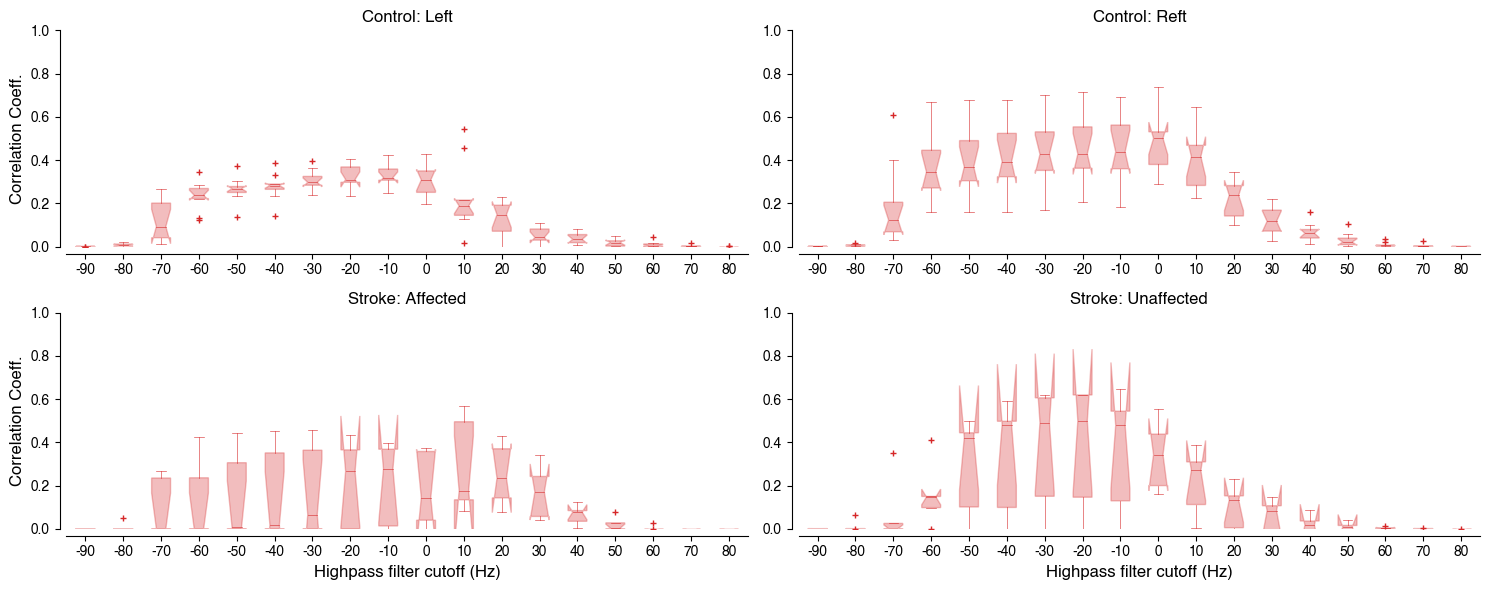

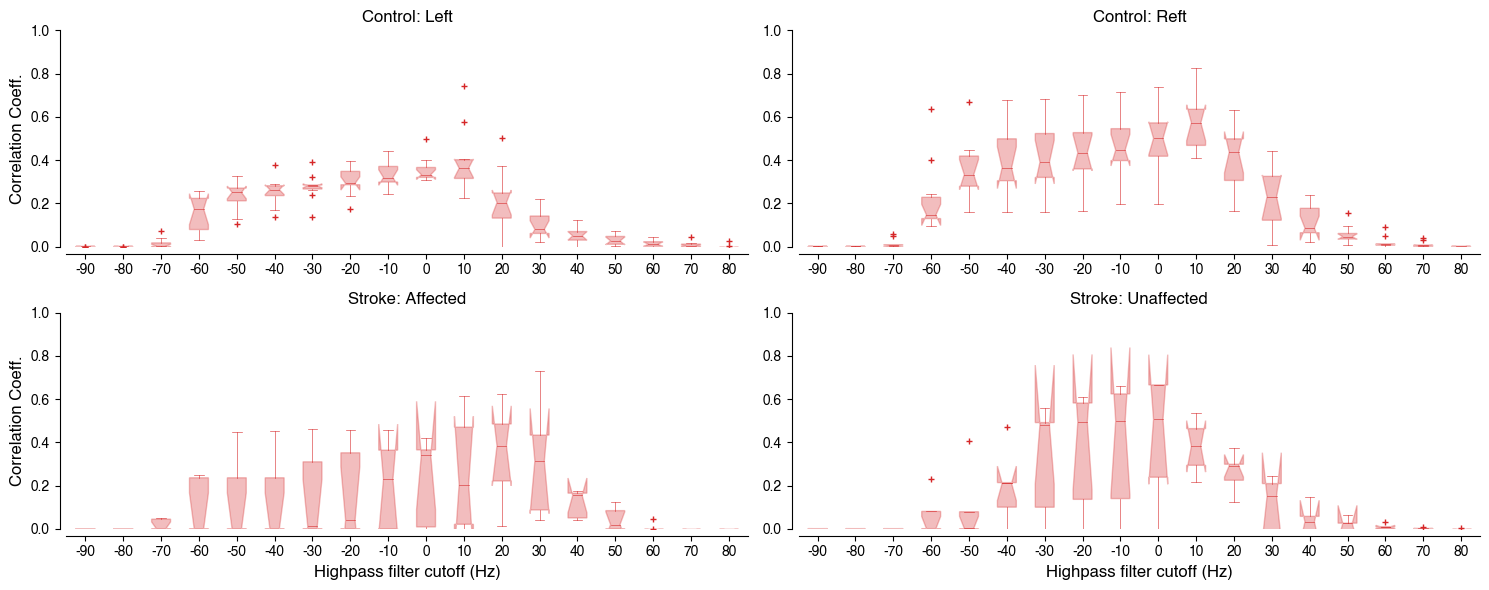

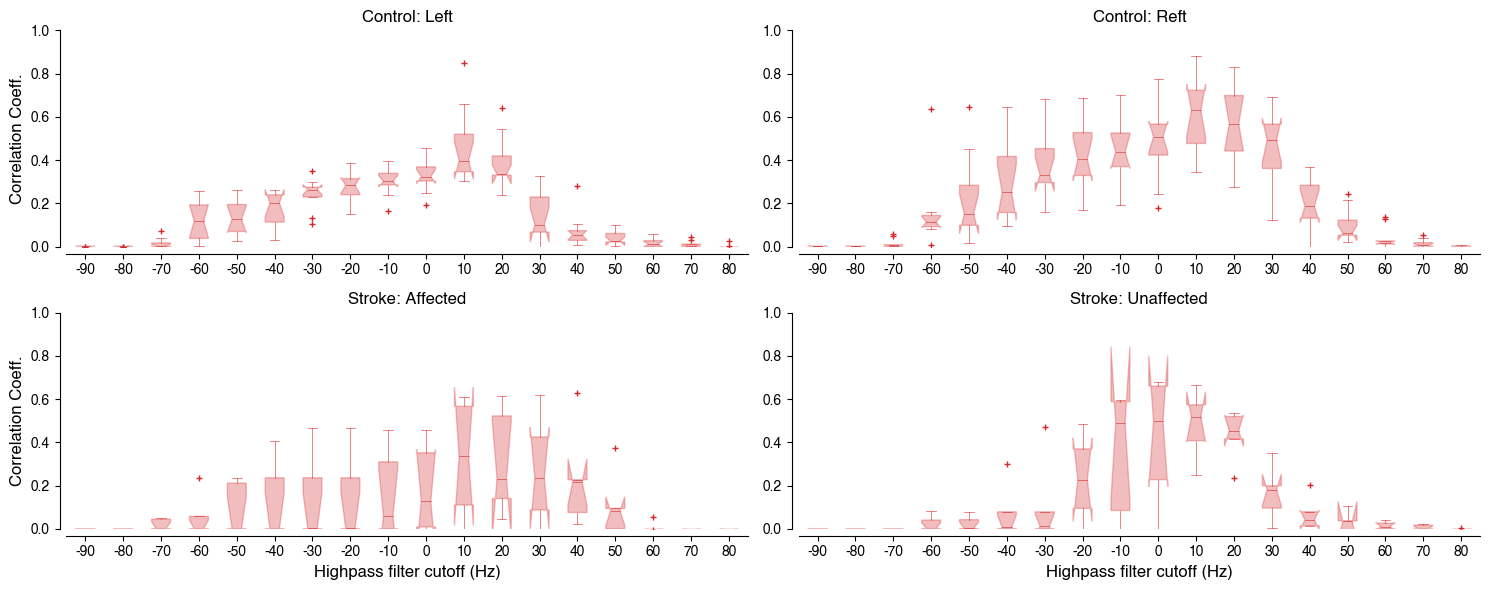

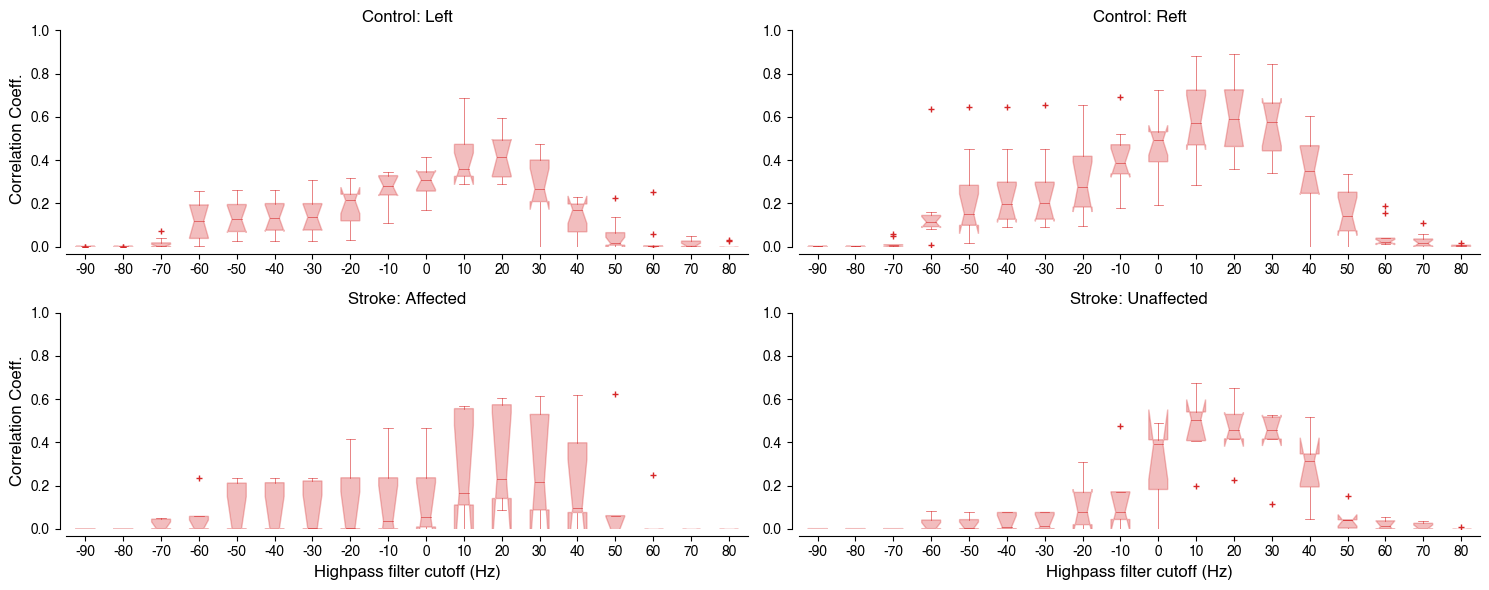

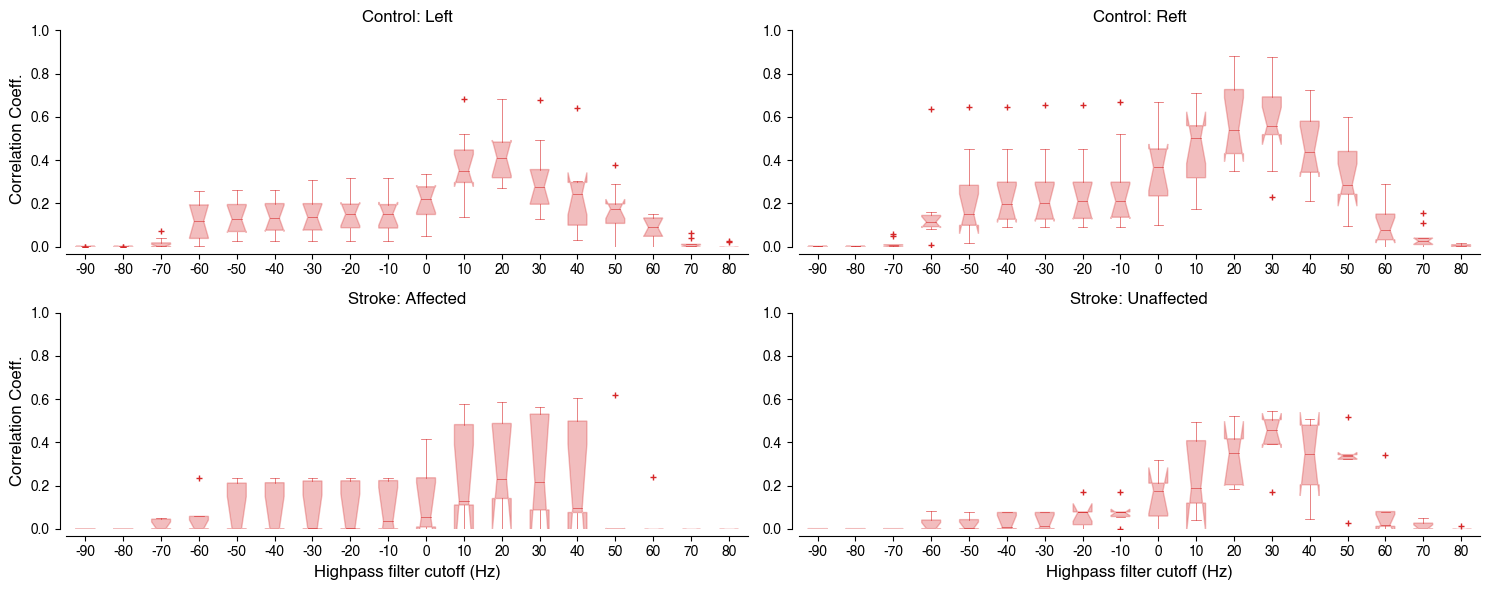

In [24]:
# Effect of pitch threshold.
for j, _pthbval in enumerate(am_param_ranges["p_th_band"]):
    fig = plt.figure(figsize=(15, 6))
    for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
        ax = fig.add_subplot(2, 2, j+1)
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) & 
                    (gmac_perf_df[_lmb]["p_th_band"] == _pthbval) & 
                    (gmac_perf_df[_lmb]["am_th"] == -1))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            ax.boxplot(x=_yi, positions=[i],
                    widths=0.5, notch=True, patch_artist=True,
                    boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                    capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                    whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                    flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                    markerfacecolor='tab:red', marker='+', markersize=4),
                    medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
            ax.set_ylim(0.0, 1.0)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_position(('outward', 5))
            ax.spines['bottom'].set_position(('outward', 5))
            ax.set_title(f"{_lmb}", fontsize=12)
            if _lmb == "left":
                ax.set_title("Control: Left", fontsize=12)
            elif _lmb == "right":
                ax.set_title("Control: Reft", fontsize=12)
            elif _lmb == "aff":
                ax.set_title("Stroke: Affected", fontsize=12)
            else:
                ax.set_title("Stroke: Unaffected", fontsize=12)
            
            if j // 2 == 1:
                ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
            if j % 2 == 0:
                ax.set_ylabel("Correlation Coeff.", fontsize=12)
        
        ax.set_xticklabels(am_param_ranges["p_th"])
    plt.tight_layout()

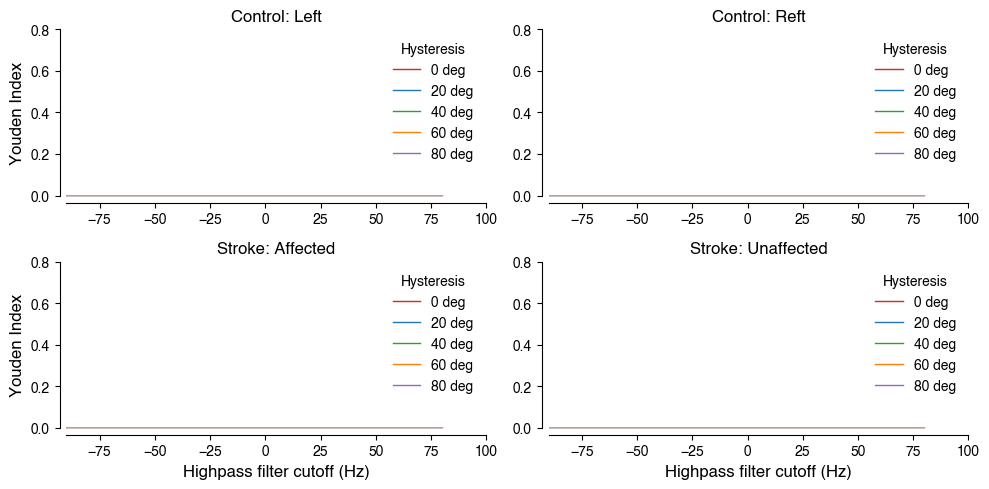

In [28]:
# Effect of pitch threshold.
fig = plt.figure(figsize=(10, 5))
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple"]
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for k, _pthbval in enumerate(am_param_ranges["p_th_band"]):
        # if k % 2 != 0:
        #     continue
        _yivals = []
        for i, _pval in enumerate(am_param_ranges["p_th"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                    (gmac_perf_df[_lmb]["p_th_band"] == _pthbval) &
                    (gmac_perf_df[_lmb]["am_th"] == 1))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
        
        # Plot values.
        _yivals = np.array(_yivals).astype(float)
        ax.plot(am_param_ranges["p_th"], _yivals[:, 1], color=colors[k], lw=1,
                label=f"{_pthbval} deg")
        ax.fill_between(x=am_param_ranges["p_th"], y1=_yivals[:, 0],
                        y2=_yivals[:, 2], color=colors[k], lw=0.5, alpha=0.1)
        ax.set_ylim(0.0, 0.8)
        ax.set_xlim(-90, 100)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Youden Index", fontsize=12)
    _l = ax.legend(loc=1, fontsize=10, frameon=False)
    _l.set_title("Hysteresis")
    plt.tight_layout()

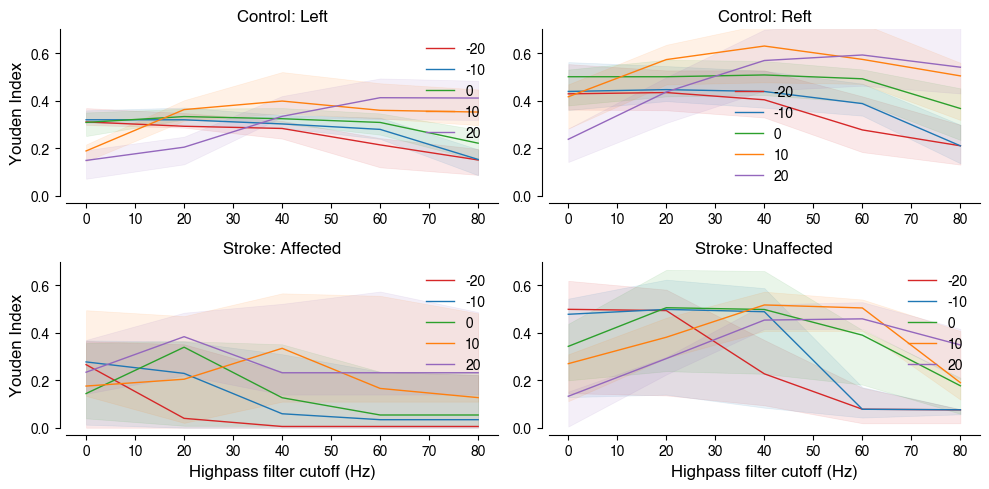

In [32]:
# Effect of pitch threshold.
fig = plt.figure(figsize=(10, 5))
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple"]
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    # for k, _amval in enumerate(am_param_ranges["am_th"]):
    for k, _pval in enumerate(np.arange(-20, 30, 10)):
        _yivals = []
        for i, _pthbval in enumerate(am_param_ranges["p_th_band"]):
            _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) &
                    (gmac_perf_df[_lmb]["p_th_band"] == _pthbval) &
                    (gmac_perf_df[_lmb]["am_th"] == 0))
            _yi = gmac_perf_df[_lmb][_inx]["youden"].values
            _yivals.append(np.nanpercentile(_yi, [25, 50, 75]))
        
        # Plot values.
        _yivals = np.array(_yivals).astype(float)
        ax.plot(am_param_ranges["p_th_band"], _yivals[:, 1], color=colors[k], lw=1,
                label=f"{_pval}")
        ax.fill_between(x=am_param_ranges["p_th_band"], y1=_yivals[:, 0],
                        y2=_yivals[:, 2], color=colors[k], lw=0.5, alpha=0.1)
        ax.set_ylim(0.0, 0.7)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Youden Index", fontsize=12)
    ax.legend(loc=0, fontsize=10, frameon=False)
    plt.tight_layout()

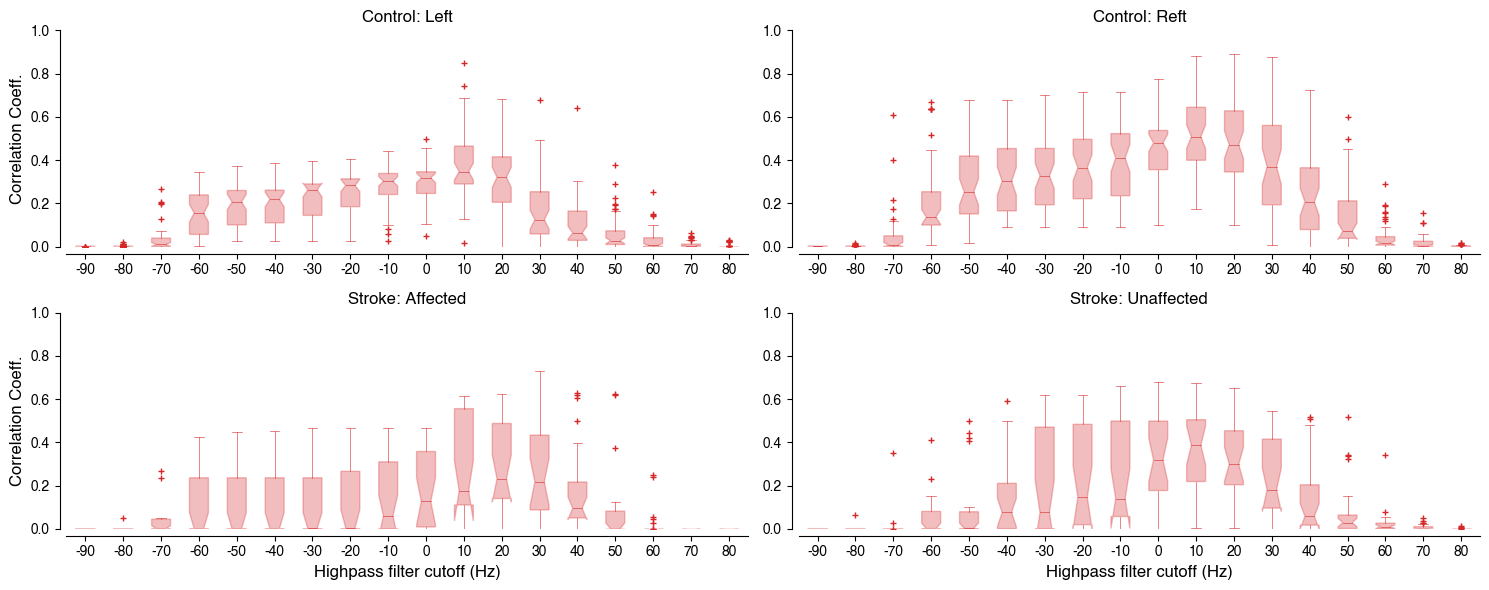

In [33]:
# Effect of pitch threshold.
# for j, _pthbval in enumerate(am_param_ranges["p_th_band"]):
fig = plt.figure(figsize=(15, 6))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for i, _pval in enumerate(am_param_ranges["p_th"]):
        _inx = ((gmac_perf_df[_lmb]["p_th"] == _pval) & 
                # (gmac_perf_df[_lmb]["p_th_band"] == _pthbval) & 
                (gmac_perf_df[_lmb]["am_th"] == 0))
        _yi = gmac_perf_df[_lmb][_inx]["youden"].values
        ax.boxplot(x=_yi, positions=[i],
                widths=0.5, notch=True, patch_artist=True,
                boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                markerfacecolor='tab:red', marker='+', markersize=4),
                medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=12)
    
    ax.set_xticklabels(am_param_ranges["p_th"])
plt.tight_layout()

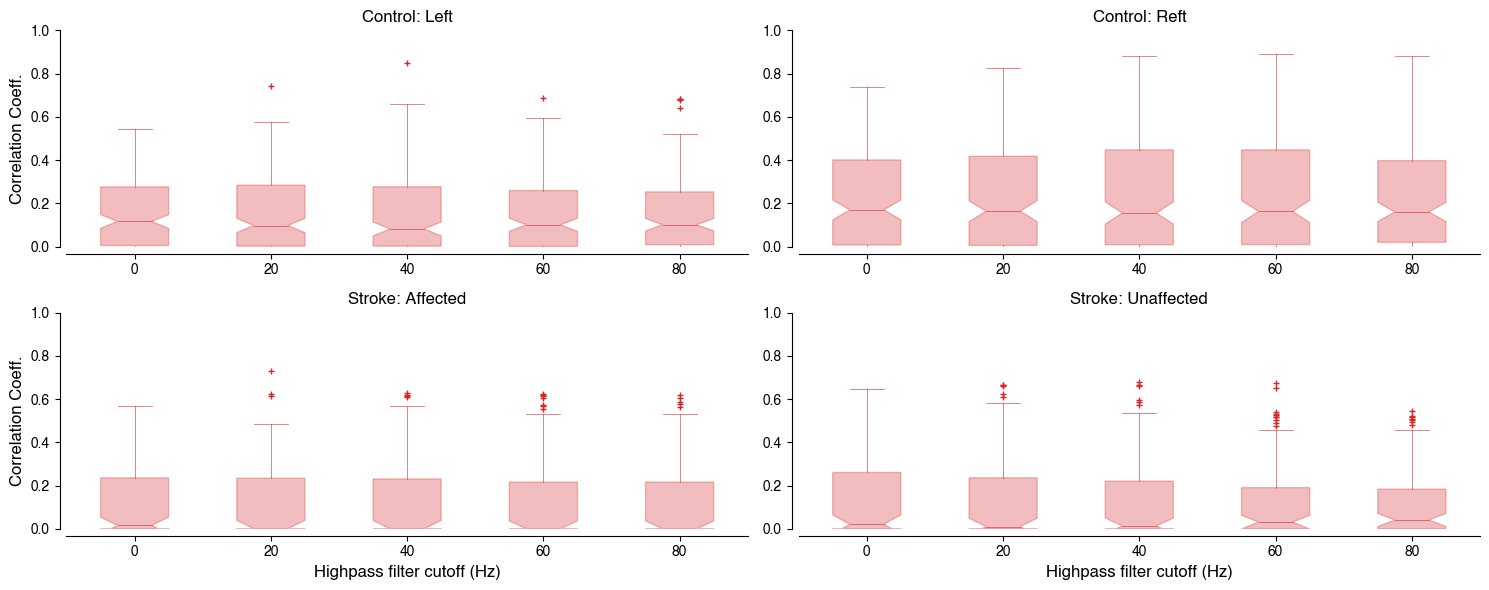

In [34]:
# Effect of pitch threshold.
# for j, _pthbval in enumerate(am_param_ranges["p_th_band"]):
fig = plt.figure(figsize=(15, 6))
for j, _lmb in enumerate(["left", "right", "aff", "unaff"]):
    ax = fig.add_subplot(2, 2, j+1)
    for i, _pval in enumerate(am_param_ranges["p_th_band"]):
        _inx = ((gmac_perf_df[_lmb]["p_th_band"] == _pval) &
                (gmac_perf_df[_lmb]["am_th"] == 0))
        _yi = gmac_perf_df[_lmb][_inx]["youden"].values
        ax.boxplot(x=_yi, positions=[i],
                widths=0.5, notch=True, patch_artist=True,
                boxprops=dict(facecolor="tab:red", color="tab:red", alpha=0.3),
                capprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                whiskerprops=dict(color="tab:red", alpha=0.8, lw=0.5),
                flierprops=dict(color="tab:red", markeredgecolor="tab:red",
                                markerfacecolor='tab:red', marker='+', markersize=4),
                medianprops=dict(color="tab:red", alpha=0.8, lw=0.5))
        ax.set_ylim(0.0, 1.0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', 5))
        ax.spines['bottom'].set_position(('outward', 5))
        ax.set_title(f"{_lmb}", fontsize=12)
        if _lmb == "left":
            ax.set_title("Control: Left", fontsize=12)
        elif _lmb == "right":
            ax.set_title("Control: Reft", fontsize=12)
        elif _lmb == "aff":
            ax.set_title("Stroke: Affected", fontsize=12)
        else:
            ax.set_title("Stroke: Unaffected", fontsize=12)
        
        if j // 2 == 1:
            ax.set_xlabel("Highpass filter cutoff (Hz)", fontsize=12)
        if j % 2 == 0:
            ax.set_ylabel("Correlation Coeff.", fontsize=12)
    
    ax.set_xticklabels(am_param_ranges["p_th_band"])
plt.tight_layout()

## Statitical Analysis of the parameters

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [36]:
gmac_perf_df["left"]["subject"] = gmac_perf_df["left"]["subject"].astype(int)
gmac_perf_df["left"]["p_th"] = gmac_perf_df["left"]["p_th"].astype(int)
gmac_perf_df["left"]["p_th_band"] = gmac_perf_df["left"]["p_th_band"].astype(int)
gmac_perf_df["right"]["subject"] = gmac_perf_df["right"]["subject"].astype(int)
gmac_perf_df["right"]["p_th"] = gmac_perf_df["right"]["p_th"].astype(int)
gmac_perf_df["right"]["p_th_band"] = gmac_perf_df["right"]["p_th_band"].astype(int)
gmac_perf_df["aff"]["subject"] = gmac_perf_df["aff"]["subject"].astype(int)
gmac_perf_df["aff"]["p_th"] = gmac_perf_df["aff"]["p_th"].astype(int)
gmac_perf_df["aff"]["p_th_band"] = gmac_perf_df["aff"]["p_th_band"].astype(int)
gmac_perf_df["unaff"]["subject"] = gmac_perf_df["unaff"]["subject"].astype(int)
gmac_perf_df["unaff"]["p_th"] = gmac_perf_df["unaff"]["p_th"].astype(int)
gmac_perf_df["unaff"]["p_th_band"] = gmac_perf_df["unaff"]["p_th_band"].astype(int)

In [37]:
lme_left = smf.mixedlm("youden ~ p_th + p_th_band + p_th * p_th_band",
                       data=gmac_perf_df["left"],
                       groups=gmac_perf_df["left"]["subject"])
lme_left.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM  Dependent Variable:  youden  
No. Observations:  900      Method:              REML    
No. Groups:        10       Scale:               0.0231  
Min. group size:   90       Log-Likelihood:      388.6563
Max. group size:   90       Converged:           Yes     
Mean group size:   90.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.145    0.009 16.010 0.000  0.127  0.163
p_th           -0.001    0.000 -4.895 0.000 -0.001 -0.000
p_th_band       0.000    0.000  0.446 0.656 -0.000  0.000
p_th:p_th_band  0.000    0.000  5.274 0.000  0.000  0.000
Group Var       0.000    0.001                           
=========================================================

"""

In [38]:
lme_right = smf.mixedlm("youden ~ p_th + p_th_band + p_th * p_th_band",
                       data=gmac_perf_df["right"],
                       groups=gmac_perf_df["right"]["subject"])
lme_right.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM  Dependent Variable:  youden 
No. Observations:   900      Method:              REML   
No. Groups:         10       Scale:               0.0488 
Min. group size:    90       Log-Likelihood:      42.4979
Max. group size:    90       Converged:           Yes    
Mean group size:    90.0                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.222    0.026  8.390 0.000  0.170  0.273
p_th           -0.001    0.000 -4.501 0.000 -0.002 -0.001
p_th_band       0.000    0.000  1.382 0.167 -0.000  0.001
p_th:p_th_band  0.000    0.000  5.777 0.000  0.000  0.000
Group Var       0.005    0.013                           
=========================================================

"""

In [39]:
lme_aff = smf.mixedlm("youden ~ p_th + p_th_band + p_th * p_th_band",
                       data=gmac_perf_df["aff"],
                       groups=gmac_perf_df["aff"]["subject"])
lme_aff.fit(method='bfgs').summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM  Dependent Variable:  youden  
No. Observations:  450      Method:              REML    
No. Groups:        5        Scale:               0.0216  
Min. group size:   90       Log-Likelihood:      187.5617
Max. group size:   90       Converged:           Yes     
Mean group size:   90.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.124    0.053  2.319 0.020  0.019  0.228
p_th           -0.000    0.000 -0.497 0.619 -0.001  0.000
p_th_band      -0.000    0.000 -0.643 0.520 -0.001  0.000
p_th:p_th_band  0.000    0.000  1.985 0.047  0.000  0.000
Group Var       0.014    0.067                           
=========================================================

"""

In [40]:
lme_unaff = smf.mixedlm("youden ~ p_th + p_th_band + p_th * p_th_band",
                       data=gmac_perf_df["unaff"],
                       groups=gmac_perf_df["unaff"]["subject"])
lme_unaff.fit(method='bfgs').summary()

/Users/siva82kb/anaconda3/envs/gmac/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM  Dependent Variable:  youden 
No. Observations:   450      Method:              REML   
No. Groups:         5        Scale:               0.0414 
Min. group size:    90       Log-Likelihood:      44.9398
Max. group size:    90       Converged:           Yes    
Mean group size:    90.0                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.118    0.041  2.863 0.004  0.037  0.199
p_th           -0.001    0.000 -4.454 0.000 -0.002 -0.001
p_th_band       0.000    0.000  0.167 0.868 -0.001  0.001
p_th:p_th_band  0.000    0.000  5.033 0.000  0.000  0.000
Group Var       0.007    0.026                           
=========================================================

"""